Loaded data:
                      pollution  dew  temp   press  wnd_spd  snow  rain
date                                                                  
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0     6.25     2     0


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


Selected Lag Order:
  VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        29.23       29.23   4.928e+12       29.23
1        9.376       9.387   1.180e+04       9.380
2        9.127       9.148       9203.       9.134
3        8.949       8.979       7698.       8.958
4        8.895       8.935       7293.       8.907
5        8.874       8.924       7146.       8.890
6        8.852       8.912       6988.       8.871
7        8.841       8.911       6915.       8.863
8        8.833       8.912       6858.       8.858
9        8.819       8.908       6759.       8.847
10       8.799       8.898       6629.       8.830
11       8.774       8.882       6463.       8.808
12       8.743       8.861       6266.       8.780
13       8.718       8.846       6111.       8.758
14       8.693       8.831       5963.       8.737
15      8.668*      8.815*      5813.*      8.714*
----------

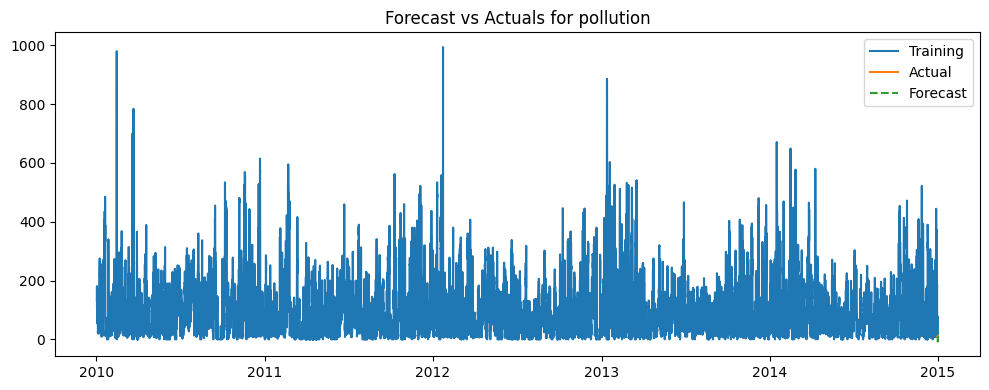

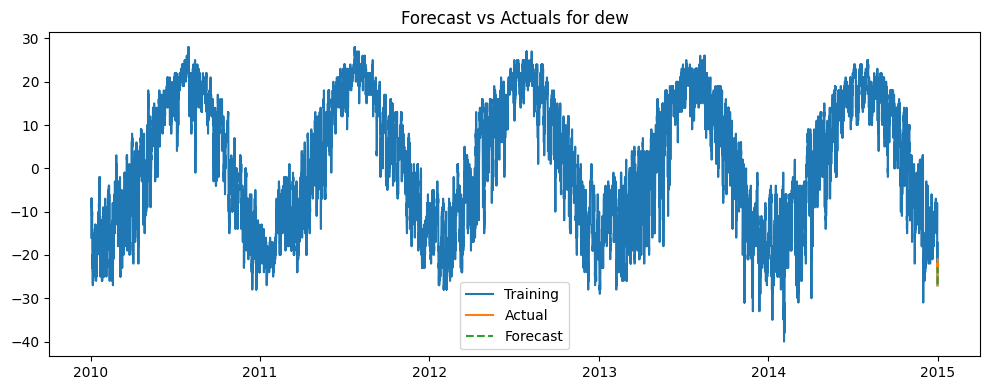

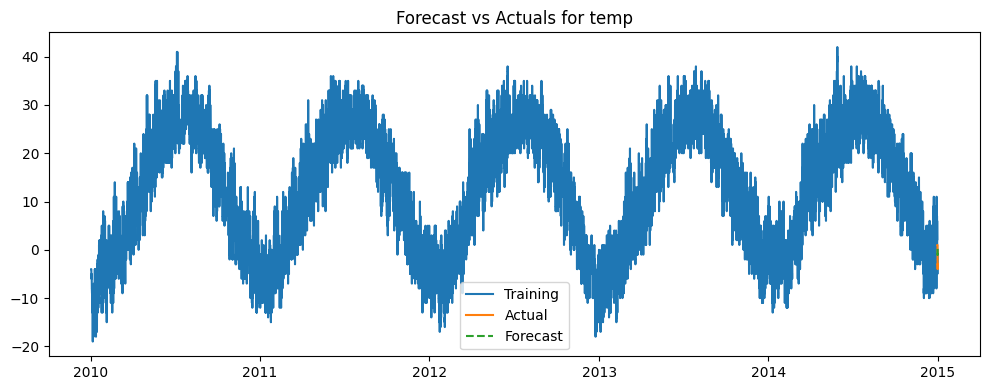

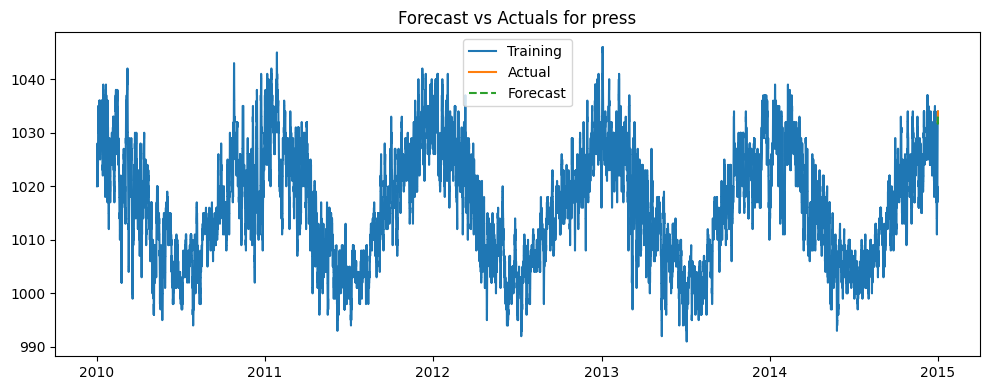

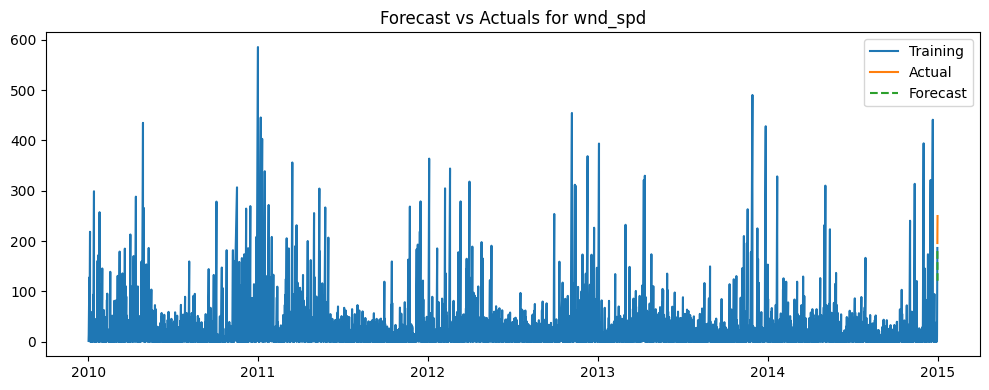

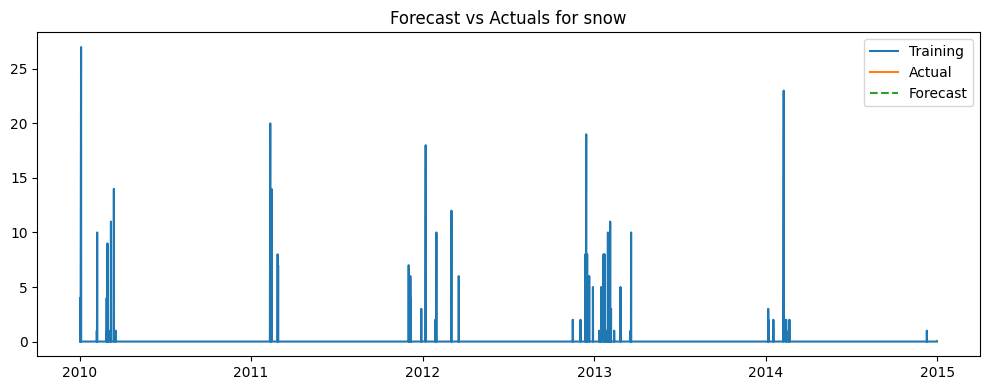

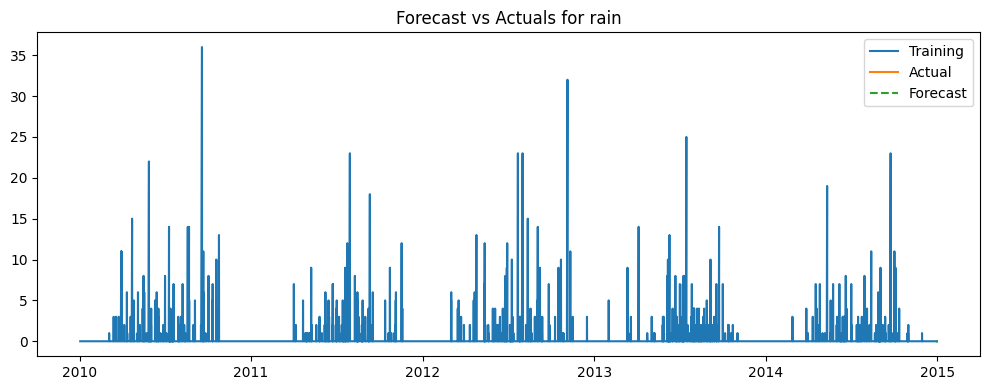

RMSE for pollution: 10.88
RMSE for dew: 1.91
RMSE for temp: 1.65
RMSE for press: 1.05
RMSE for wnd_spd: 85.18
RMSE for snow: 0.05
RMSE for rain: 0.02


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse

# Load dataset using correct datetime column
df = pd.read_csv('/content/LSTM-Multivariate_pollution.csv', parse_dates=['date'])
df.set_index('date', inplace=True)

# Drop categorical column (if exists) and missing values
if 'wnd_dir' in df.columns:
    df.drop('wnd_dir', axis=1, inplace=True)

df.dropna(inplace=True)

print("Loaded data:\n", df.head())

# Convert all columns to float
df = df.astype(float)

# Split into train and test
n_obs = 10
train, test = df[:-n_obs], df[-n_obs:]

# Fit the VAR model
model = VAR(train)

# Select optimal lag order
lag_order = model.select_order(maxlags=15)
print("Selected Lag Order:\n", lag_order.summary())

# Fit the model using the best lag from AIC
model_fitted = model.fit(lag_order.aic)
print(model_fitted.summary())

# Forecast
forecast_input = train.values[-model_fitted.k_ar:]
forecast = model_fitted.forecast(y=forecast_input, steps=n_obs)

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)
print("\nForecast:\n", forecast_df)

# Plot actual vs forecast for each column
for column in df.columns:
    plt.figure(figsize=(10, 4))
    plt.plot(train.index, train[column], label='Training')
    plt.plot(test.index, test[column], label='Actual')
    plt.plot(forecast_df.index, forecast_df[column], label='Forecast', linestyle='--')
    plt.title(f'Forecast vs Actuals for {column}')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Calculate RMSE for each variable
for col in df.columns:
    error = rmse(test[col], forecast_df[col])
    print(f'RMSE for {col}: {error:.2f}')
